In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt

from scipy.special import logsumexp

import geometry
import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import geometry_v2
import cpb

import cpb_gaussian
import bpm
import random_algo
import plotly.graph_objects as go
import TSPM

import PM_DMED

#import ucbTSPM_v2
import cpb_gaussian_v2
import feedexp3_piccolboni

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []

    for jobid in range(n_folds):
        
        if type == 'easy' :
            p = np.random.uniform(0, 0.2) if np.random.uniform(0,1)>0.5 else np.random.uniform(0.8, 1)
        #elif type == 'easy' and jobid > 100:
        #    p = np.random.uniform(0.8, 1)
        else:
            p = np.random.uniform(0.4,0.6)
        distributions.append( [p, 1-p] )


    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,range(n_folds)) ) ) 


class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, jobid = job


        np.random.seed(jobid)
        
        # outcome_distribution =  {'spam':0.05,'ham':0.95}

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        # p = get_easy() if game.mode == 'easy' else get_harsch() 
        # outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        # print('optimal action', game.i_star)

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:

                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return regret


In [3]:
import numpy as np

np.random.seed(1)
distributions = []

for jobid in range(100):
        
    if type == 'easy' :
        p = np.random.uniform(0, 0.2) if np.random.uniform(0,1)>0.5 else np.random.uniform(0.8, 1)
        #elif type == 'easy' and jobid > 100:
        #    p = np.random.uniform(0.8, 1)
    else:
        p = np.random.uniform(0.4,0.6)
    distributions.append( [p, 1-p] )


In [4]:


n_cores = 1
n_folds = 1
horizon = 1000

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

game =  games.apple_tasting( False ) 

# print('optimal action', game.i_star)
alg = PM_DMED.PM_DMED(  game, horizon, 1)
task = Evaluation(horizon, 'easy')

# forced stop dist {'spam': 0.8131922181368049, 'ham': 0.18680778186319513} jobid 95
# forced stop dist {'spam': 0.8468724172242842, 'ham': 0.1531275827757158} jobid 98
idx = 4
outcome_distribution = distributions[idx]
job = (outcome_distribution, idx )

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 

n-actions 2 n-outcomes 2 alphabet 2
Restricted license - for non-production use only - expires 2023-10-25


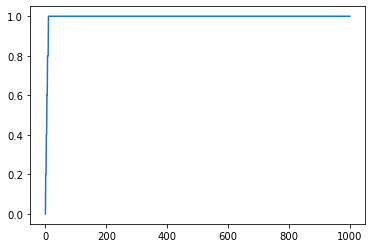

In [5]:
plt.plot(result)

In [ ]:
n_cores = 16
n_folds = 100
horizon = 100000

game = games.apple_tasting(False)


algos = [   random_algo.Random(  game, horizon, ),

            #feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10, False), 

            PM_DMED.PM_DMED(  game, horizon, 1),    

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0],  [0,250,0], [0,125,0], [250,0,250] ,[0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    # result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    # np.save('./results/apple_tasting/easy_{}_{}_{}'.format(horizon,n_folds, label), result)

    result = np.load('./results/apple_tasting/easy_{}_{}_{}.npy'.format(horizon,n_folds, label) )

    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    
    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )   )
    
# fig.show(legend=True)

fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.update_yaxes( type="log", range=[0, 5] )

# fig.write_image("./easy_AT.pdf")

# fig.update_yaxes(range=[0, 15] )

fig.write_image("./easy_AT.pdf")

# fig.show()

In [ ]:
n_cores = 16
n_folds = 100
horizon = 100000

game = games.apple_tasting(False)

algos = [   random_algo.Random(  game, horizon, ),

            # feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10, False), 

            PM_DMED.PM_DMED(  game, horizon, 1),    

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0],  [0,250,0], [0,125,0], [250,0,250] ,[0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'CBP', 'RandCBP', 'PM_DMEDc1', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    # result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'hard')
    result = np.load('./results/apple_tasting/hard_{}_{}_{}.npy'.format(horizon,n_folds, label) )

    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    # np.save('./results/apple_tasting/easy_{}_{}_{}'.format(horizon,n_folds, label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )   )
    
# fig.show(legend=True)

fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )


fig.update_yaxes(range=[0, 270] )

fig.write_image("./hard_AT.pdf")

fig.show()